In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4396,00021687_002.png,No Finding,2,21687,069Y,F,PA,2496,3056,0.139,0.139
1735,00009140_002.png,No Finding,2,9140,063Y,F,PA,2500,2048,0.168,0.168
3805,00018689_003.png,No Finding,3,18689,032Y,M,PA,2992,2991,0.143,0.143


In [11]:
print("We have in total "+str(len(all_xray_df))+" Images from "+str(len(all_xray_df['Patient ID'].unique()))+" Patients")

We have in total 112120 Images from 30805 Patients


In [6]:
unique_labels = all_xray_df['Finding Labels'].str.split('|').explode().unique()
print(" Overall there are "+str(len(unique_labels))+" Unique Findings :",unique_labels)


 Overall there are 15 Unique Findings : ['Cardiomegaly' 'Emphysema' 'Effusion' 'No Finding' 'Hernia'
 'Infiltration' 'Mass' 'Nodule' 'Atelectasis' 'Pneumothorax'
 'Pleural_Thickening' 'Pneumonia' 'Fibrosis' 'Edema' 'Consolidation']


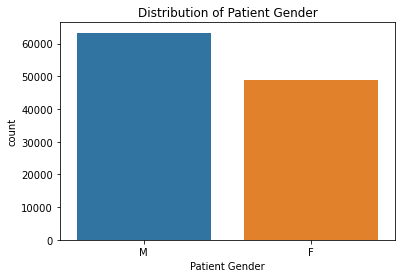

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Patient Gender', data=all_xray_df)
plt.title("Distribution of Patient Gender")
plt.show()

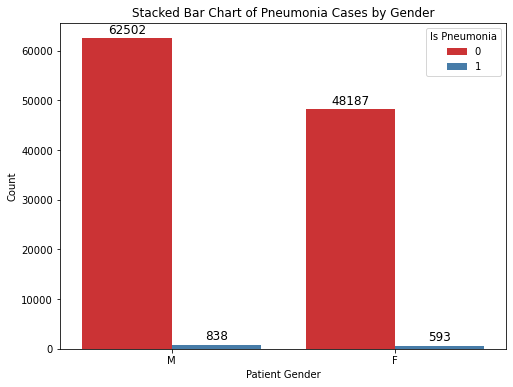

In [19]:

all_xray_df['is_pneumonia']=np.where(all_xray_df['Finding Labels'].str.contains('Pneumonia'),1,0)
gender_pneumonia_counts = all_xray_df.groupby(['Patient Gender', 'is_pneumonia']).size().reset_index(name='counts')

# Create a stacked bar chart (side-by-side plot with seaborn countplot)
plt.figure(figsize=(8, 6))
ax=sns.countplot(data=all_xray_df, x='Patient Gender', hue='is_pneumonia', palette='Set1')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.title("Stacked Bar Chart of Pneumonia Cases by Gender")
plt.xlabel("Patient Gender")
plt.ylabel("Count")
plt.legend(title="Is Pneumonia")
plt.show()

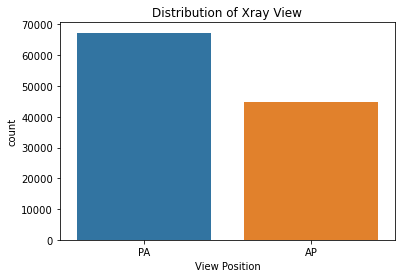

In [23]:
plt.figure(figsize=(6, 4))
sns.countplot(x='View Position', data=all_xray_df)
plt.title("Distribution of Xray View")
plt.show()

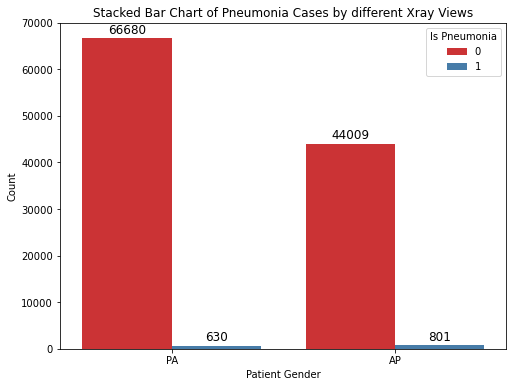

In [25]:

xray_view_pneumonia_counts = all_xray_df.groupby(['View Position', 'is_pneumonia']).size().reset_index(name='counts')

# Create a stacked bar chart (side-by-side plot with seaborn countplot)
plt.figure(figsize=(8, 6))
ax=sns.countplot(data=all_xray_df, x='View Position', hue='is_pneumonia', palette='Set1')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.title("Stacked Bar Chart of Pneumonia Cases by different Xray Views")
plt.xlabel("Patient Gender")
plt.ylabel("Count")
plt.legend(title="Is Pneumonia")
plt.show()

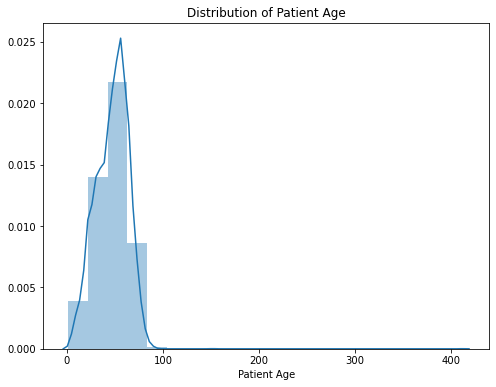

In [21]:
# Distribution of Patient Age
plt.figure(figsize=(8, 6))
sns.distplot(all_xray_df['Patient Age'], bins=20, kde=True)
plt.title("Distribution of Patient Age")
plt.show()

In [22]:
# We see records where age >100 which is most likely not possible
all_xray_df[all_xray_df['Patient Age']>100]['Patient Age']

20852     412
46965     414
48284     148
55742     148
58650     150
62929     149
74884     152
78795     151
84810     411
85404     412
86264     413
91369     412
95794     153
98495     154
101194    155
104590    155
Name: Patient Age, dtype: int64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


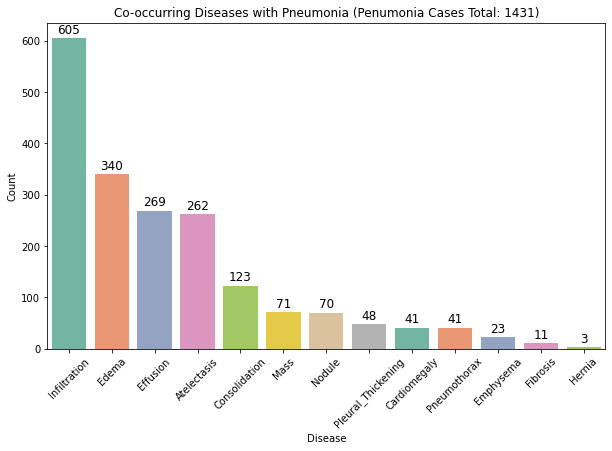

In [30]:
pneumonia_cases = all_xray_df[all_xray_df['Finding Labels'].str.contains('Pneumonia')]

# Split the 'Finding Labels' column by '|' and explode into separate rows
pneumonia_cases['Diseases'] = pneumonia_cases['Finding Labels'].str.split('|')
pneumonia_cases_exploded = pneumonia_cases.explode('Diseases')

# Remove 'Pneumonia' from the list of diseases
pneumonia_cases_exploded = pneumonia_cases_exploded[pneumonia_cases_exploded['Diseases'] != 'Pneumonia']

# Count occurrences of other diseases
disease_counts = pneumonia_cases_exploded['Diseases'].value_counts()

# Plot a bar chart for the counts of co-occurring diseases
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='Set2')

# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Final touches to the plot
plt.title("Co-occurring Diseases with Pneumonia (Penumonia Cases Total: "+str(len(pneumonia_cases))+")")
plt.xlabel("Disease")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

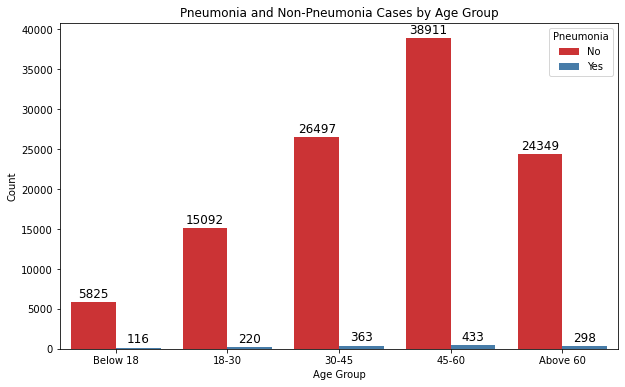

In [32]:
bins = [0, 18, 30,45, 60, 100]  # Defining the edges of the age buckets
labels = ['Below 18', '18-30', '30-45','45-60', 'Above 60']  # Labels for each bucket
all_xray_df['age_group'] = pd.cut(all_xray_df['Patient Age'], bins=bins, labels=labels)

# Plot count of pneumonia and non-pneumonia cases by age group
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=all_xray_df, x='age_group', hue='is_pneumonia', palette='Set1')

# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Final touches to the plot
plt.title("Pneumonia and Non-Pneumonia Cases by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.legend(title="Pneumonia", labels=["No", "Yes"])
plt.xticks(rotation=0)
plt.show()

In [26]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,is_pneumonia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,0


In [ ]:
## EDA
# Todo 